In [1]:
#check that we have GPU acceleration enabled

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d0fe5357-e67f-303a-f50f-668362c4bbce)


In [3]:
#install the necessary packages

%%capture install_log
!apt-get install libsox-fmt-all libsox-dev sox
!pip install sox pytube pydub crepe transformers torchtext==0.12.0 pyannote.audio

In [4]:
#copy all of our utility functions into the virtual environment 

!cp /content/drive/MyDrive/Omdena_Challenge/utils.py /content 

In [11]:
#import the necessary packages

import os 
import sys
import sox
import spacy
import crepe
import librosa
import utils as u 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pytube import YouTube
from pydub import AudioSegment
from pydub.utils import make_chunks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from lightgbm.sklearn import LGBMRegressor
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials 
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, pipeline, AutoModelForSequenceClassification, AutoTokenizer
from pyannote.audio import Inference, Model, Pipeline

In [6]:
#set up our file structure

u.make_directories(['input', 'tmp', 'user_data'])

In [7]:
#create a speaker sample

u.retrieve_audio("https://www.youtube.com/watch?v=6ObqydfPGLI", "tmp")
u.convert_to_wav('tmp/Yale Professor Tony Leiserowitz Discusses American Perceptions of Climate Change.mp4', "tmp")
tfm = sox.Transformer()
tfm.trim(10, 40)
tfm.build_file('tmp/Yale Professor Tony Leiserowitz Discusses American Perceptions of Climate Change.wav', "user_data/speaker_sample.wav")
speaker_sample = "user_data/speaker_sample.wav"

In [8]:
#retrieve and chunk additional recordings of the same speaker to simulate the activity of the user over time

u.retrieve_audio("https://www.youtube.com/watch?v=T-JVKqpvt2c&t=1996s", "tmp")
u.convert_to_wav('tmp/Dr Anthony Leiserowitzs Keynote Address - 2017 Conference.mp4', "tmp")
tfm = sox.Transformer()
tfm.trim(75, 2280)
tfm.build_file('tmp/Dr Anthony Leiserowitzs Keynote Address - 2017 Conference.wav', 'tmp/Dr_Anthony_Leiserowitzs_Keynote Address_2017_Conference_trimmed.wav')
u.chunk_audio('tmp/Dr_Anthony_Leiserowitzs_Keynote Address_2017_Conference_trimmed.wav', 'input')

In [12]:
#download the required models; to use the pyannote modules go to https://github.com/pyannote/pyannote-audio and follow the instructions

auth_token = #your huggingface authorization token here

diarization_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token=auth_token)
asr_processor = Wav2Vec2Processor.from_pretrained("gngpostalsrvc/w2v2-ami")
asr_model = Wav2Vec2ForCTC.from_pretrained("gngpostalsrvc/w2v2-ami")
inference = Inference(Model.from_pretrained("pyannote/embedding", use_auth_token=auth_token), window="whole")
emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')
lang_model = spacy.load("en_core_web_sm")
topic_tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/tweet-topic-21-multi')
topic_model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/tweet-topic-21-multi')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/96.4M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [13]:
output = pd.DataFrame(columns=['date', 'mutual_silence', 'overlap_duration', 'interruptions', 'total_turn_duration', 'speaking_percent', 'response_time', 'emotions', 'topic_shifts', 'words_per_minute', 'fillerword_percent', 'mean_spectral_flatness', 'spectral_flatness_std', 'mean_pitch', 'pitch_std', 'mean_volume', 'volume_std', 'is_group', 'skill', 'score'])

In [14]:
np.random.seed(42) #set the random seed to insure reproducibility

for chunk in os.listdir('input'):

  chunk = {'name' : chunk.split(".")[0], 'audio' : f"input/{chunk}"}

  features = u.get_features(chunk, speaker_sample, diarization_pipeline, asr_processor, asr_model, emotion, topic_tokenizer, topic_model, inference, lang_model, threshold=.1)

  features['skill'] = 'communication'
  features['score'] = np.random.randint(6) 
  output = output.append(features, ignore_index=True)

88/88 [==============================] - 11s 55ms/step


82/82 [==============================] - 5s 57ms/step


90/90 [==============================] - 5s 56ms/step


91/91 [==============================] - 4s 49ms/step


91/91 [==============================] - 4s 49ms/step


71/71 [==============================] - 3s 49ms/step


91/91 [==============================] - 4s 49ms/step


RuntimeError: ignored

In [ ]:
#clean up unneeded files

for file in os.scandir('input'):
  os.remove(file.path)

In [ ]:
#save the data to csv for later use

output.to_csv('user_data/output.csv')

In [ ]:
#examine the data 

output.head()

In [ ]:
"""generate a lgbm model based on the data and calculate the most important features (note: the MSE from the model will be relatively high 
and the important features will appear arbitrary because the independent variables remain fairly constant in this toy example)"""

model, feature_importances = u.generate_lgbm_model(output, 'communication')

NameError: ignored

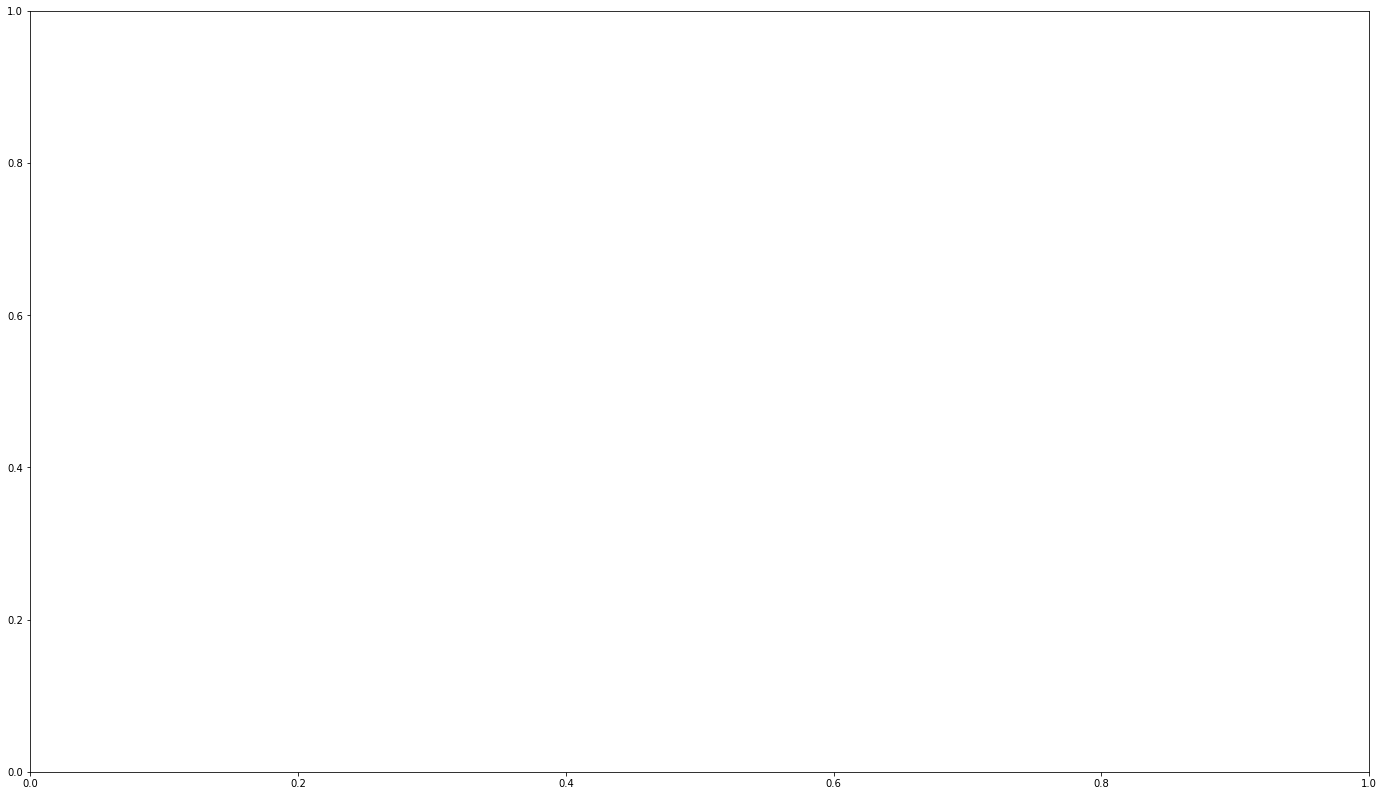

In [ ]:
#visualize feature importances

fig, ax = plt.subplots(figsize=(24, 14))
sns.barplot(y='Feature', x='Importance', data=feature_importances, orient='h')
plt.title('Feature Importances for Communication')
plt.show();

In [ ]:
model.booster_.save_model('communication_model.txt')

NameError: ignored

In [ ]:
!cp /content/communication_model.txt /content/drive/MyDrive/Omdena_Challenge

In [ ]:
!cp /content/user_data/output.csv /content/drive/MyDrive/Omdena_Challenge